# STAT 654 Project

1. Introduction

2. Data preparation

    A. Load data
    
    B. Normalization, Reshape and Label encoding
    
    C. Visualize test and train sample
    
3. Model Building

    A. Split training and valdiation set
    
    B. Data augmentation
    
    C. Loading VGG16
    
    D. Defining and Training a model.
    
4. Evaluate the model

    A. Training and validation curves
    
5. Fine Tunning

    A. Take the Feature Extraction(We are did this step) and Select layers to Fine Tunning

    B. Train Tuned Model
    
    C. Training and validation curves of Tuned Model

## 1. Introduction

This kernel is basic start in deep learning.

CIFAR-10 (Canadian Institute For Advanced Research) is the type “hello world” dataset of computer vision. This dataset is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. In this competition, your goal is to correctly identify different object from a dataset of tens of thousands of color images.

In [1]:
from keras import layers
from keras import models
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.datasets import cifar10
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Dataset Description:

* train.7z - a folder containing the training images in png format
* test.7z - a folder containing the test images in png format
* trainLabels.csv - the training labels
* sampleSubmission.csv - We have to predict labels for all 300,000 images.

Train and Test files are present a .7z compressed format. You can process file from .7z extension code is given below, but it will take long enough time to process.

In [2]:
def graph(history):
    epoklar = range(1,len(history["loss"])+1)
    
    plt.plot(epoklar,history["loss"],label="Training Loss")
    plt.plot(epoklar,history["val_loss"],label="Validation Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()
    
    plt.plot(epoklar,history["acc"],label="Training Accuracy")
    plt.plot(epoklar,history["val_acc"],label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.show()

## 2. Data Preparation
###  A. Load Data

In [3]:
(train_images,train_labels),(test_images,test_labels) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


### B. Normalization, Reshape and Label encoding

In [4]:
def resize(images):
    yeni = np.zeros((images.shape[0],96,96,3),dtype=np.float32)
    for i in range(len(images)):
        yeni[i] = cv2.resize(images[i,:,:,:],(96,96))
    return yeni

In [5]:
train_images = resize(train_images)
test_images = resize(test_images)

In [6]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 96, 96, 3)
(50000, 1)
(10000, 96, 96, 3)
(10000, 1)


In [7]:
numberOfClass = len(np.unique(train_labels))
numberOfClass

10

### C. Visualize test and train sample

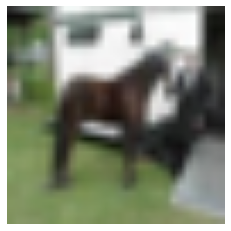

In [8]:
plt.imshow(test_images[20].astype(np.uint8))
plt.axis("off")
plt.show()

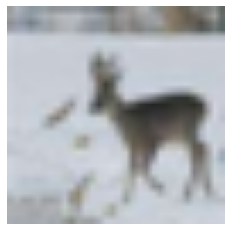

In [9]:
plt.imshow(train_images[20].astype(np.uint8))
plt.axis("off")
plt.show()

In [10]:
#one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

## 3.Model Building

### A. Split training and valdiation set

In [11]:
#x_train,x_valid,y_train,y_valid = train_test_split(train_images,train_labels,test_size = 0.3, random_state = 40,stratify = train_labels)

x_train = train_images[:42500]
y_train = train_labels[:42500]
x_valid = train_images[42500:]
y_valid = train_labels[42500:]

x_test = test_images
y_test = test_labels

### B. Data augmentation

In [12]:
#data augmentation and normalize images with using ImageDataGenerator
train_datagen = image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=0.15,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

valid_datagen = image.ImageDataGenerator(rescale=1./255)
test_datagen = image.ImageDataGenerator(rescale=1./255)

In [13]:
def generator(data,x,y,batch_size):
    return data.flow(x,y,batch_size=batch_size)    

In [14]:
batch_size = 128
epoch = 30r
size = x_train.shape[1:]

In [15]:
train_generator = generator(train_datagen,x_train,y_train,batch_size=batch_size)
valid_generator = generator(valid_datagen,x_valid,y_valid,batch_size=batch_size)
test_generator =  generator(test_datagen,x_test,y_test,batch_size=batch_size)

 ### C. Loading VGG16

In [16]:
vgg16 = VGG16(weights="imagenet",include_top=False,input_shape=size)

58892288/58889256 [==============================] - 2s 0us/step


In [17]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

### D. Defining and Training a model.

In [22]:
def model(train, valid, epochs):
    
    #create new model and add pretrained model in this model
    model = models.Sequential()
    for i in range(len(vgg16.layers)):
        model.add(vgg16.layers[i])

    for i in range(len(model.layers)): #freeze pretrained model
        model.layers[i].trainable = False

    #add new layers your model
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.40))
    model.add(layers.Dense(256,activation="relu"))
    model.add(layers.Dense(numberOfClass,activation="softmax"))

    model.compile(optimizer="adam",loss="categorical_crossentropy",
                  metrics=["acc",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

    history = model.fit_generator(generator=train,
                    steps_per_epoch=len(train),epochs=epochs,
                    validation_data=valid,
                    validation_steps=len(valid))
    return model, history

In [23]:
Model = model(train=train_generator,valid=valid_generator,epochs=epoch)

Epoch 1/30
333/333 [==============================] - 97s 291ms/step - loss: 1.3137 - acc: 0.5406 - recall_2: 0.2837 - precision_2: 0.6792 - val_loss: 0.9737 - val_acc: 0.6832 - val_recall_2: 0.3849 - val_precision_2: 0.7209
Epoch 2/30
333/333 [==============================] - 95s 284ms/step - loss: 1.1451 - acc: 0.6004 - recall_2: 0.4132 - precision_2: 0.7308 - val_loss: 0.8472 - val_acc: 0.6857 - val_recall_2: 0.4324 - val_precision_2: 0.7382
Epoch 3/30
333/333 [==============================] - 94s 283ms/step - loss: 1.0877 - acc: 0.6206 - recall_2: 0.4453 - precision_2: 0.7432 - val_loss: 0.7136 - val_acc: 0.7035 - val_recall_2: 0.4563 - val_precision_2: 0.7468
Epoch 4/30
333/333 [==============================] - 95s 285ms/step - loss: 1.0533 - acc: 0.6306 - recall_2: 0.4644 - precision_2: 0.7503 - val_loss: 0.8931 - val_acc: 0.6827 - val_recall_2: 0.4707 - val_precision_2: 0.7523
Epoch 5/30
333/333 [==============================] - 95s 285ms/step - loss: 1.0396 - acc: 0.6352 - 


## 4.Evaluate the model

### A. Training and validation curves

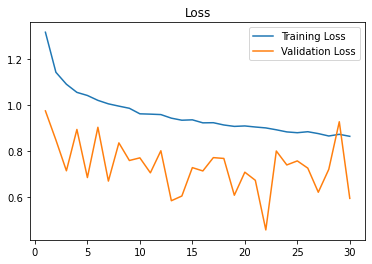

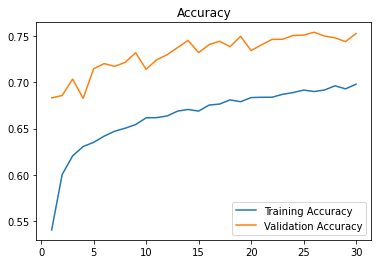

In [24]:
graph(Model[1].history)

In [29]:
loss,acc,recall,precision = Model[0].evaluate_generator(test_generator,
                        steps=len(test_generator))
print("Test Accuracy =",acc,'\t',"Test Recall ",recall,'\t',"Test Precision",precision)

Test Accuracy = 0.7437000274658203 	 Test Recall  0.5677573084831238 	 Test Precision 0.7877589464187622


## 5. Fine Tunning


### A. Take the Feature Extraction(We did this step) and Select layers to Fine Tunning

In [30]:
from keras import optimizers

In [31]:
def TunedModel(train, valid, epochs):


    #create new model and add pretrained model in this model
    model = models.Sequential()
    for i in range(len(vgg16.layers)):
        model.add(vgg16.layers[i])

    #select after blocks block4_conv1 to fine tunnig
    trnable = False
    for i in model.layers:
        if i.name == "block4_conv1":
            trnable = True
        i.trainable = trnable

    #add new layers your model
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.40))
    model.add(layers.Dense(256,activation="relu"))
    model.add(layers.Dense(numberOfClass,activation="softmax"))

    model.compile(optimizer= optimizers.Adam(lr=1e-5),loss="categorical_crossentropy",
                  metrics=["acc",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

    history = model.fit_generator(generator=train,
                    steps_per_epoch=len(train),epochs=epochs,
                    validation_data=valid,
                    validation_steps=len(valid))
    return model, history

In [32]:
epoch = 50

### B. Train Tuned Model

In [33]:
Model1 = TunedModel(train=train_generator,valid=valid_generator,epochs=epoch)

Epoch 1/50
333/333 [==============================] - 103s 308ms/step - loss: 1.4999 - acc: 0.4637 - recall_3: 0.1275 - precision_3: 0.5513 - val_loss: 0.7596 - val_acc: 0.7339 - val_recall_3: 0.3141 - val_precision_3: 0.7228
Epoch 2/50
333/333 [==============================] - 99s 298ms/step - loss: 0.9028 - acc: 0.6865 - recall_3: 0.4006 - precision_3: 0.7507 - val_loss: 0.5692 - val_acc: 0.7925 - val_recall_3: 0.4613 - val_precision_3: 0.7688
Epoch 3/50
333/333 [==============================] - 100s 299ms/step - loss: 0.7402 - acc: 0.7407 - recall_3: 0.5020 - precision_3: 0.7820 - val_loss: 0.4763 - val_acc: 0.8195 - val_recall_3: 0.5355 - val_precision_3: 0.7928
Epoch 4/50
333/333 [==============================] - 99s 296ms/step - loss: 0.6529 - acc: 0.7744 - recall_3: 0.5612 - precision_3: 0.8013 - val_loss: 0.5981 - val_acc: 0.8304 - val_recall_3: 0.5830 - val_precision_3: 0.8083
Epoch 5/50
333/333 [==============================] - 98s 293ms/step - loss: 0.5893 - acc: 0.7956 

### C. Training and validation curves of Tuned Model

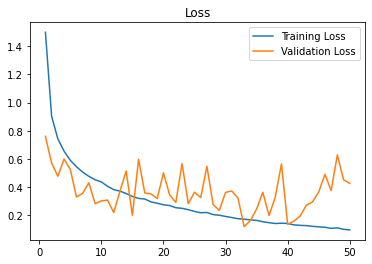

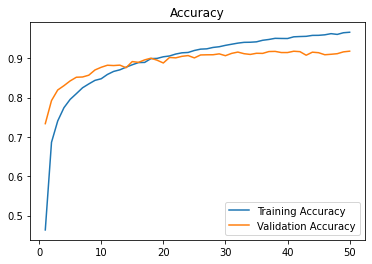

In [34]:
graph(Model1[1].history)

In [35]:
loss,acc,recall,precision = Model1[0].evaluate_generator(test_generator,
                        steps=len(test_generator))
print("Test Accuracy =",acc,'\t',"Test Recall ",recall,'\t',"Test Precision",precision)

Test Accuracy = 0.9186000227928162 	 Test Recall  0.871047854423523 	 Test Precision 0.9235092401504517
